Xelectron_data shape: (249000, 32, 32, 2)
yelectron_data shape: (249000,) 1.0
Xphoton_data shape: (249000, 32, 32, 2)
yphoton_data shape: (249000,) 0.0


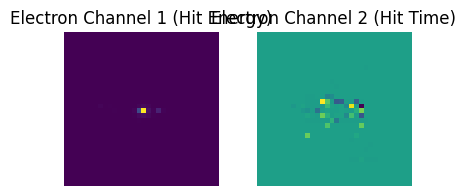

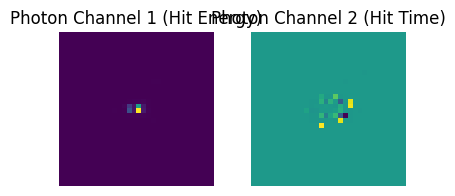

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np


def load_hdf5_data(file_path):
    with h5py.File(file_path, 'r') as file:
        X_data = file['X'][:]
        y_data = file['y'][:]
    return X_data, y_data

def visualize_sample(sample, title_prefix=''):
    channel_1 = sample[:, :, 0]
    channel_2 = sample[:, :, 1]

    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    axs[0].imshow(channel_1, cmap='viridis')
    axs[0].set_title(f'{title_prefix} Channel 1 (Hit Energy)')
    axs[0].axis('off')

    axs[1].imshow(channel_2, cmap='viridis')
    axs[1].set_title(f'{title_prefix} Channel 2 (Hit Time)')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# File paths
electron_file = '/kaggle/input/some-electron-data-or-smthin-from-cern/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
photon_file = '/kaggle/input/some-electron-data-or-smthin-from-cern/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'

# Load data
Xelectron_data, yelectron_data = load_hdf5_data(electron_file)
Xphoton_data, yphoton_data = load_hdf5_data(photon_file)
Xelectron_data=np.array(Xelectron_data)
Xphoton_data=np.array(Xphoton_data)
yelectron_data=np.array(yelectron_data)
yphoton_data=np.array(yphoton_data)
X=np.concatenate((Xphoton_data,Xelectron_data))
y=np.concatenate((yphoton_data,yelectron_data))
# Print shapes
print("Xelectron_data shape:", Xelectron_data.shape)
print("yelectron_data shape:", yelectron_data.shape,max(yelectron_data))
print("Xphoton_data shape:", Xphoton_data.shape)
print("yphoton_data shape:", yphoton_data.shape,max(yphoton_data))

# Visualize samples
visualize_sample(Xelectron_data[0], 'Electron')
visualize_sample(Xphoton_data[0], 'Photon')

In [2]:
import random 
a=list(range(len(X)))
random.shuffle(a) 
print(type(a))
print(a[:100])
Xsh=X[a]
ysh=y[a]
Xsh.shape,X.shape,y.shape,ysh.shape

<class 'list'>
[338700, 489249, 67957, 346195, 319296, 382889, 133660, 98534, 176359, 278435, 101695, 184404, 439212, 497676, 300197, 447080, 254978, 407036, 124815, 254539, 194753, 40295, 71265, 49868, 268203, 143887, 124999, 171291, 159058, 275983, 421575, 188127, 138999, 377917, 482137, 160233, 225736, 405393, 244590, 122223, 268002, 230905, 444186, 74087, 22803, 92405, 170772, 416185, 54803, 416977, 26343, 457589, 203475, 478498, 8432, 83012, 486211, 448656, 149309, 97402, 363454, 253012, 429123, 294683, 181683, 202437, 131150, 258408, 216809, 229635, 447763, 119360, 338127, 97176, 177934, 413854, 45629, 250654, 335978, 138058, 147699, 302780, 38310, 34164, 372197, 394256, 328679, 101316, 404910, 393461, 113591, 69012, 15913, 38023, 225972, 47016, 438095, 180028, 367845, 402689]


((498000, 32, 32, 2), (498000, 32, 32, 2), (498000,), (498000,))

In [3]:
import torch
Xsh_tensor = torch.tensor(Xsh, dtype=torch.float32)  # Convert to tensor with appropriate dtype
Xsh_tensor = Xsh_tensor.permute(0, 3, 1, 2)

import torch.nn.functional as F

# Example tensor with values 1 and 0
yshtensor = torch.tensor(ysh,dtype=torch.int64)

# One-hot encoding (assuming two classes: 0 and 1)
ysh_one_hot = F.one_hot(yshtensor, num_classes=2)
ysh_one_hot.to(torch.float32)
torch.unique(yshtensor)

tensor([0, 1])

In [4]:
Xsh_tensor.shape

torch.Size([498000, 2, 32, 32])

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
torch.cuda.empty_cache()

batch_size =256# You can adjust this based on your memory constraints

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xsh_tensor=Xsh_tensor.to(device)
tr=int(0.8*len(Xsh_tensor))
ysh_one_hot=ysh_one_hot.float()
ysh_one_hot=ysh_one_hot.to(device)
yshtensor=yshtensor.long()
yshtensor=yshtensor.to(device)
dataset = TensorDataset(Xsh_tensor[:tr], ysh_one_hot[:tr])
# dataset.to(device)
dataset2 =TensorDataset(Xsh_tensor[:tr], yshtensor[:tr])
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
train_loader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=False)
full=TensorDataset(Xsh_tensor,ysh_one_hot)
full_loader=DataLoader(full,batch_size=batch_size,shuffle=False)
test=TensorDataset(Xsh_tensor[tr:],ysh_one_hot[tr:])
test_loader=DataLoader(test,batch_size=batch_size,shuffle=False)
#2
full2=TensorDataset(Xsh_tensor,yshtensor)
full_loader2=DataLoader(full2,batch_size=batch_size,shuffle=False)
test2=TensorDataset(Xsh_tensor[tr:],yshtensor[tr:])
test_loader2=DataLoader(test2,batch_size=batch_size,shuffle=False)

In [6]:
from tqdm import tqdm
def accuracy(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in tqdm( dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)  # Get predictions
            predicted = outputs.argmax(dim=1)  # Convert logits to class indices
            
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    return correct / total  # Return accuracy as a fraction
def acc():
    a=[]
    res.eval()
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(test_loader2):
            test_preds=res(inputs)
            a.append(accuracy(test_preds,targets))
    print(f'test acc:{sum(a)/len(test_loader)//0.01/100}')
def acc2():
    a=[]
    res.eval()
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(train_loader2):
            train_preds=res(inputs)
            a.append(accuracy(train_preds,targets))
    print(f'train acc:{sum(a)/len(train_loader)//0.01/100}  ',end="")

In [7]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, batch_first=True)

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert to (batch, seq_len=1, features)
        x, _ = self.attn(x, x, x)  # Self-attention
        return x.squeeze(1)  # Remove sequence dimension

class resnet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Initial convolutional layers (2 → 1024 channels)
        self.initial = nn.Sequential(
            ConvBlock(2, 256, kernel_size=7, stride=2, padding=3),
            ConvBlock(256, 512, kernel_size=3, stride=2, padding=1),
            ConvBlock(512, 1024, kernel_size=3, stride=2, padding=1)
        )

        # Adaptive Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 14 Fully Connected Layers with Residual Connections
        self.fc_layers = nn.ModuleList()
        in_features = 1024

        for _ in range(7):  # Each "block" has 2 FCs with skip connection
            self.fc_layers.append(nn.Linear(in_features, 1024))
            self.fc_layers.append(nn.BatchNorm1d(1024))
            self.fc_layers.append(nn.ReLU(inplace=True))
            self.fc_layers.append(nn.Linear(1024, 1024))
            self.fc_layers.append(nn.BatchNorm1d(1024))

        # Self-Attention after FC layers
        self.attention = SelfAttention(embed_dim=1024)

        # Final Layers: Dropout → FC → BN → Dropout → ReLU → FC
        self.final_fc1 = nn.Linear(1024, 1024)
        self.final_bn = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.2)
        self.final_relu = nn.ReLU(inplace=True)
        self.final_fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Fully Connected Layers with Skip Connections
        for i in range(0, len(self.fc_layers), 5):
            identity = x
            x = self.fc_layers[i](x)
            x = self.fc_layers[i + 1](x)
            x = self.fc_layers[i + 2](x)
            x = self.fc_layers[i + 3](x)
            x = self.fc_layers[i + 4](x)
            x += identity  # Skip connection
            x = nn.ReLU(inplace=True)(x)  # Activation after skip

        # Self-Attention
        # x = self.attention(x)
        # x = self.dropout(x)

        # Final Layers
        x = self.final_fc1(x)
        x = self.final_bn(x)
        x = self.dropout(x)
        x = self.final_relu(x)
        x = self.final_fc2(x)

        return x


In [8]:
import torch

In [9]:
import torch.nn as nn
mod=resnet()
# mod.load_state_dict(torch.load(f="/kaggle/working/model 735.pth"))
mod=mod.to(device)
# return
res=mod.to(device)
l=[]
acclist=[]
accelist=[]
loss_fn=nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.Adam(res.parameters(), lr=0.03)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=1)

In [11]:
trainable_params = sum(p.numel() for p in res.parameters() if p.requires_grad)
print(trainable_params)

25902082


In [12]:
epochs = 31
from tqdm import tqdm

a = len(train_loader)

for epoch in range(epochs):
    lossl = []
    res.train()  # Set the model to training mode

    progress_bar = tqdm(train_loader2, desc=f"Epoch {epoch}", ncols=70)

    for inputs, targets in progress_bar:
        y_pred = res(inputs.to(device))  # Ensure inputs are on the correct device
        loss = loss_fn(y_pred, targets.long().to(device))  # Ensure targets are on the correct device

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossl.append(loss.item())  # Store loss as a scalar
        
        # Update tqdm bar with avg loss
        avg_loss = sum(lossl) / len(lossl)
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
        l.append(avg_loss)

    scheduler.step(int(100 * avg_loss))
    
    print(f"\nEpoch {epoch} - Avg Loss: {avg_loss:.4f}")
    ta=accuracy(res,train_loader2,device)
    tea=accuracy(res,test_loader2,device)
    acclist.append(ta)
    accelist.append(tea)
    print("Train acc" ,ta,"test acc",tea)
    
    for param_group in optimizer.param_groups:
        print("Current Learning Rate:", param_group['lr'])
    if ta>0.7:
        print("Model saved")
        torch.save(res.state_dict(), f"model_{epoch}.pth")
    # if epoch % 10 == 0:


Epoch 0: 100%|███████| 1557/1557 [01:30<00:00, 17.25it/s, loss=0.6906]



Epoch 0 - Avg Loss: 0.6906


100%|██████████| 390/390 [00:07<00:00, 55.03it/s]


Train acc 0.6657730923694779 test acc 0.6640261044176707
Current Learning Rate: 0.03


Epoch 1: 100%|███████| 1557/1557 [01:29<00:00, 17.45it/s, loss=0.5959]



Epoch 1 - Avg Loss: 0.5959


100%|██████████| 390/390 [00:06<00:00, 56.55it/s]


Train acc 0.6766616465863454 test acc 0.6755421686746987
Current Learning Rate: 0.03


Epoch 2: 100%|███████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5758]



Epoch 2 - Avg Loss: 0.5758


100%|██████████| 390/390 [00:06<00:00, 56.46it/s]


Train acc 0.7054593373493976 test acc 0.7061044176706828
Current Learning Rate: 0.03
Model saved


Epoch 3: 100%|███████| 1557/1557 [01:29<00:00, 17.45it/s, loss=0.5698]



Epoch 3 - Avg Loss: 0.5698


100%|██████████| 390/390 [00:07<00:00, 55.22it/s]


Train acc 0.7121962851405622 test acc 0.7113955823293173
Current Learning Rate: 0.03
Model saved


Epoch 4: 100%|███████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5665]



Epoch 4 - Avg Loss: 0.5665


100%|██████████| 390/390 [00:06<00:00, 55.78it/s]


Train acc 0.6726104417670683 test acc 0.6719076305220884
Current Learning Rate: 0.03


Epoch 5: 100%|███████| 1557/1557 [01:29<00:00, 17.37it/s, loss=0.5635]



Epoch 5 - Avg Loss: 0.5635


100%|██████████| 390/390 [00:06<00:00, 56.27it/s]


Train acc 0.7244477911646586 test acc 0.7227409638554216
Current Learning Rate: 0.009
Model saved


Epoch 6: 100%|███████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5508]



Epoch 6 - Avg Loss: 0.5508


100%|██████████| 390/390 [00:07<00:00, 55.46it/s]


Train acc 0.7322816265060241 test acc 0.728785140562249
Current Learning Rate: 0.009
Model saved


Epoch 7: 100%|███████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5479]



Epoch 7 - Avg Loss: 0.5479


100%|██████████| 390/390 [00:06<00:00, 56.61it/s]


Train acc 0.7346084337349398 test acc 0.7303815261044176
Current Learning Rate: 0.009
Model saved


Epoch 8: 100%|███████| 1557/1557 [01:29<00:00, 17.35it/s, loss=0.5452]



Epoch 8 - Avg Loss: 0.5452


100%|██████████| 390/390 [00:06<00:00, 56.35it/s]


Train acc 0.734964859437751 test acc 0.7304016064257028
Current Learning Rate: 0.009
Model saved


Epoch 9: 100%|███████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5432]



Epoch 9 - Avg Loss: 0.5432


100%|██████████| 390/390 [00:07<00:00, 55.42it/s]


Train acc 0.7322941767068273 test acc 0.7270481927710843
Current Learning Rate: 0.0026999999999999997
Model saved


Epoch 10: 100%|██████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5357]



Epoch 10 - Avg Loss: 0.5357


100%|██████████| 390/390 [00:06<00:00, 56.44it/s]


Train acc 0.739515562248996 test acc 0.7313152610441767
Current Learning Rate: 0.0026999999999999997
Model saved


Epoch 11: 100%|██████| 1557/1557 [01:29<00:00, 17.38it/s, loss=0.5337]



Epoch 11 - Avg Loss: 0.5337


100%|██████████| 390/390 [00:06<00:00, 56.23it/s]


Train acc 0.7408157630522089 test acc 0.7318373493975904
Current Learning Rate: 0.0026999999999999997
Model saved


Epoch 12: 100%|██████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5322]



Epoch 12 - Avg Loss: 0.5322


100%|██████████| 390/390 [00:06<00:00, 56.34it/s]


Train acc 0.7414106425702811 test acc 0.7314759036144578
Current Learning Rate: 0.0008099999999999998
Model saved


Epoch 13: 100%|██████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5288]



Epoch 13 - Avg Loss: 0.5288


100%|██████████| 390/390 [00:06<00:00, 56.43it/s]


Train acc 0.74347640562249 test acc 0.7327409638554216
Current Learning Rate: 0.0008099999999999998
Model saved


Epoch 14: 100%|██████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5275]



Epoch 14 - Avg Loss: 0.5275


100%|██████████| 390/390 [00:06<00:00, 56.53it/s]


Train acc 0.7440687751004016 test acc 0.7327911646586346
Current Learning Rate: 0.0008099999999999998
Model saved


Epoch 15: 100%|██████| 1557/1557 [01:29<00:00, 17.43it/s, loss=0.5267]



Epoch 15 - Avg Loss: 0.5267


100%|██████████| 390/390 [00:06<00:00, 56.52it/s]


Train acc 0.7445281124497992 test acc 0.7325401606425703
Current Learning Rate: 0.00024299999999999994
Model saved


Epoch 16: 100%|██████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5256]



Epoch 16 - Avg Loss: 0.5256


100%|██████████| 390/390 [00:06<00:00, 56.45it/s]


Train acc 0.7451154618473895 test acc 0.7325602409638554
Current Learning Rate: 0.00024299999999999994
Model saved


Epoch 17: 100%|██████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5250]



Epoch 17 - Avg Loss: 0.5250


100%|██████████| 390/390 [00:06<00:00, 56.33it/s]


Train acc 0.7452836345381526 test acc 0.7326204819277109
Current Learning Rate: 7.289999999999998e-05
Model saved


Epoch 18: 100%|██████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5245]



Epoch 18 - Avg Loss: 0.5245


100%|██████████| 390/390 [00:07<00:00, 55.13it/s]


Train acc 0.745519578313253 test acc 0.7327510040160643
Current Learning Rate: 7.289999999999998e-05
Model saved


Epoch 19: 100%|██████| 1557/1557 [01:29<00:00, 17.40it/s, loss=0.5243]



Epoch 19 - Avg Loss: 0.5243


100%|██████████| 390/390 [00:06<00:00, 56.13it/s]


Train acc 0.7455622489959839 test acc 0.732640562248996
Current Learning Rate: 2.1869999999999996e-05
Model saved


Epoch 20: 100%|██████| 1557/1557 [01:29<00:00, 17.38it/s, loss=0.5242]



Epoch 20 - Avg Loss: 0.5242


100%|██████████| 390/390 [00:06<00:00, 56.02it/s]


Train acc 0.7455647590361446 test acc 0.7327208835341366
Current Learning Rate: 2.1869999999999996e-05
Model saved


Epoch 21: 100%|██████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5240]



Epoch 21 - Avg Loss: 0.5240


100%|██████████| 390/390 [00:07<00:00, 55.39it/s]


Train acc 0.7455496987951807 test acc 0.7327309236947791
Current Learning Rate: 6.560999999999999e-06
Model saved


Epoch 22: 100%|██████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5239]



Epoch 22 - Avg Loss: 0.5239


100%|██████████| 390/390 [00:06<00:00, 56.43it/s]


Train acc 0.7455471887550201 test acc 0.7327510040160643
Current Learning Rate: 6.560999999999999e-06
Model saved


Epoch 23: 100%|██████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5238]



Epoch 23 - Avg Loss: 0.5238


100%|██████████| 390/390 [00:06<00:00, 56.57it/s]


Train acc 0.7455371485943775 test acc 0.7327510040160643
Current Learning Rate: 1.9682999999999994e-06
Model saved


Epoch 24: 100%|██████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5238]



Epoch 24 - Avg Loss: 0.5238


100%|██████████| 390/390 [00:06<00:00, 56.43it/s]


Train acc 0.7455120481927711 test acc 0.7327409638554216
Current Learning Rate: 1.9682999999999994e-06
Model saved


Epoch 25: 100%|██████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5240]



Epoch 25 - Avg Loss: 0.5240


100%|██████████| 390/390 [00:06<00:00, 56.35it/s]


Train acc 0.7455120481927711 test acc 0.7327309236947791
Current Learning Rate: 5.904899999999998e-07
Model saved


Epoch 26: 100%|██████| 1557/1557 [01:29<00:00, 17.40it/s, loss=0.5237]



Epoch 26 - Avg Loss: 0.5237


100%|██████████| 390/390 [00:06<00:00, 56.40it/s]


Train acc 0.7455170682730924 test acc 0.7327309236947791
Current Learning Rate: 5.904899999999998e-07
Model saved


Epoch 27: 100%|██████| 1557/1557 [01:29<00:00, 17.42it/s, loss=0.5241]



Epoch 27 - Avg Loss: 0.5241


100%|██████████| 390/390 [00:06<00:00, 56.38it/s]


Train acc 0.7455170682730924 test acc 0.7327309236947791
Current Learning Rate: 1.7714699999999994e-07
Model saved


Epoch 28: 100%|██████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5238]



Epoch 28 - Avg Loss: 0.5238


100%|██████████| 390/390 [00:06<00:00, 56.41it/s]


Train acc 0.7455220883534136 test acc 0.7327309236947791
Current Learning Rate: 1.7714699999999994e-07
Model saved


Epoch 29: 100%|██████| 1557/1557 [01:29<00:00, 17.39it/s, loss=0.5240]



Epoch 29 - Avg Loss: 0.5240


100%|██████████| 390/390 [00:06<00:00, 56.27it/s]


Train acc 0.7455271084337349 test acc 0.7327309236947791
Current Learning Rate: 5.314409999999998e-08
Model saved


Epoch 30: 100%|██████| 1557/1557 [01:29<00:00, 17.41it/s, loss=0.5241]



Epoch 30 - Avg Loss: 0.5241


100%|██████████| 390/390 [00:06<00:00, 56.19it/s]


Train acc 0.7455296184738955 test acc 0.7327208835341366
Current Learning Rate: 5.314409999999998e-08
Model saved


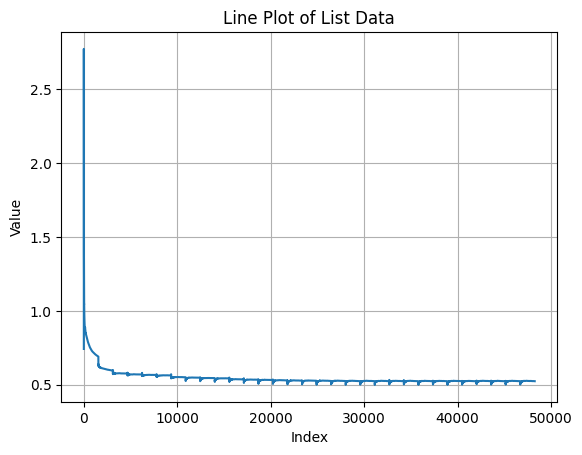

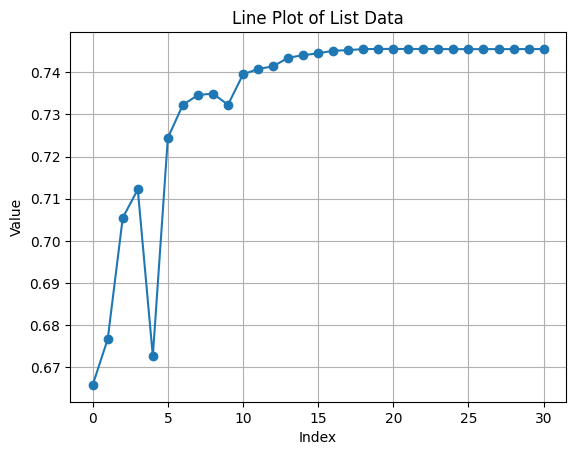

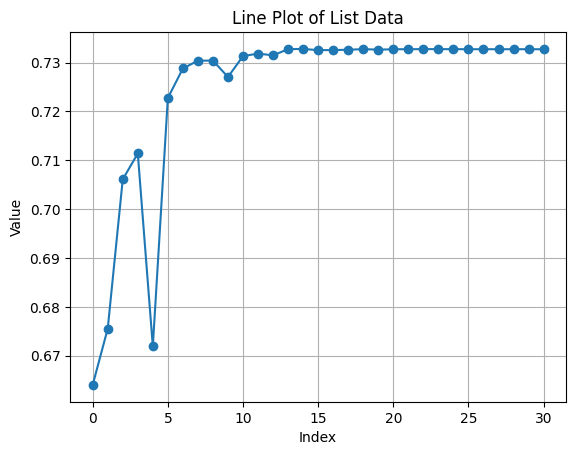

In [13]:
import matplotlib.pyplot as plt

# data = [1, 3, 5, 7, 9, 11]  # Example list

plt.plot(l, linestyle='-')  # Line plot with markers
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Plot of List Data")
plt.grid(True)
plt.show()

plt.plot(acclist, marker='o', linestyle='-')  # Line plot with markers
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Plot of List Data")
plt.grid(True)
plt.show()

plt.plot(accelist, marker='o', linestyle='-')  # Line plot with markers
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Plot of List Data")
plt.grid(True)
plt.show()


Epoch 1,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.68it/s]
avg loss: tensor(0.5989, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.28  test acc:69.97
Epoch 2,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5935, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.32  test acc:70.09
Epoch 3,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5912, device='cuda:0', grad_fn=<DivBackward0>)train acc:69.78  test acc:69.42
Epoch 4,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5888, device='cuda:0', grad_fn=<DivBackward0>)train acc:69.9  test acc:69.5
Epoch 5,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5867, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.38  test acc:70.04
Epoch 6,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5855, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.86  test acc:70.63
Epoch 7,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5849, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.19  test acc:69.88
Epoch 8,: 100%|███████████████████| 1992/1992 [04:18<00:00,  7.69it/s]
avg loss: tensor(0.5840, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.09  test acc:70.87
Epoch 9,: 100%|███████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5834, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.58  test acc:70.22
Epoch 10,: 100%|██████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5829, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.62  test acc:70.37
Epoch 11,: 100%|██████████████████| 1992/1992 [04:19<00:00,  7.69it/s]
avg loss: tensor(0.5825, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.64  test acc:70.35
Epoch 12,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5824, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.1  test acc:70.74
Epoch 13,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5821, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.86  test acc:70.53
Epoch 14,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5817, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.75  test acc:70.42
Epoch 15,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5817, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.5  test acc:71.29
Epoch 16,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5812, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.74  test acc:71.39
Epoch 17,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5813, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.53  test acc:71.29
Epoch 18,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5812, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.69  test acc:71.41
Epoch 19,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5812, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.43  test acc:71.18
Epoch 20,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5813, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.56  test acc:71.32
Epoch 21,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5808, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.65  test acc:71.38
Epoch 22,: 100%|██████████████████| 1992/1992 [04:18<00:00,  7.70it/s]
avg loss: tensor(0.5808, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.3  test acc:70.96
Epoch 23,:   8%|█▌                 | 165/1992 [00:21<03:56,  7.74it/s]

In [14]:
# Epoch 1,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.7078, device='cuda:0', grad_fn=<DivBackward0>)train acc:54.2  test acc:54.0
# Epoch 2,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6889, device='cuda:0', grad_fn=<DivBackward0>)train acc:61.01  test acc:61.11
# Epoch 3,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6719, device='cuda:0', grad_fn=<DivBackward0>)train acc:61.51  test acc:61.68
# Epoch 4,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6629, device='cuda:0', grad_fn=<DivBackward0>)train acc:61.51  test acc:61.68
# Epoch 5,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6579, device='cuda:0', grad_fn=<DivBackward0>)train acc:61.82  test acc:61.84
# Epoch 6,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6511, device='cuda:0', grad_fn=<DivBackward0>)train acc:64.95  test acc:64.74
# Epoch 7,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6371, device='cuda:0', grad_fn=<DivBackward0>)train acc:67.22  test acc:66.85
# Epoch 8,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6179, device='cuda:0', grad_fn=<DivBackward0>)train acc:68.04  test acc:67.53
# Epoch 9,: 100%|█████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6086, device='cuda:0', grad_fn=<DivBackward0>)train acc:69.17  test acc:68.64
# Epoch 10,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.6025, device='cuda:0', grad_fn=<DivBackward0>)train acc:69.53  test acc:68.92
# model saved
# Epoch 11,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5976, device='cuda:0', grad_fn=<DivBackward0>)train acc:69.73  test acc:69.12
# Epoch 12,: 100%|████████████████████| 200/200 [00:59<00:00,  3.34it/s]
# avg loss: tensor(0.5934, device='cuda:0', grad_fn=<DivBackward0>)train acc:69.96  test acc:69.31
# Epoch 13,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5902, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.32  test acc:69.6
# Epoch 14,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5883, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.56  test acc:69.75
# Epoch 15,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5860, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.71  test acc:69.92
# Epoch 16,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5842, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.59  test acc:69.8
# Epoch 17,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5824, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.58  test acc:69.77
# Epoch 18,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5807, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.72  test acc:69.97
# Epoch 19,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5797, device='cuda:0', grad_fn=<DivBackward0>)train acc:70.68  test acc:69.99
# Epoch 20,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5771, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.11  test acc:70.24
# model saved
# Epoch 21,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5758, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.4  test acc:70.42
# Epoch 22,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5743, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.5  test acc:70.45
# Epoch 23,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5731, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.4  test acc:70.47
# Epoch 24,: 100%|████████████████████| 200/200 [00:59<00:00,  3.34it/s]
# avg loss: tensor(0.5714, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.67  test acc:70.57
# Epoch 25,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5700, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.75  test acc:70.73
# Epoch 26,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5687, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.03  test acc:70.72
# Epoch 27,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5673, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.8  test acc:70.71
# Epoch 28,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5663, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.14  test acc:70.81
# Epoch 29,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5648, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.93  test acc:70.73
# Epoch 30,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5636, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.22  test acc:70.76
# model saved
# Epoch 31,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5630, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.2  test acc:70.77
# Epoch 32,: 100%|████████████████████| 200/200 [00:59<00:00,  3.34it/s]
# avg loss: tensor(0.5622, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.27  test acc:70.83
# Epoch 33,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5606, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.65  test acc:70.96
# Epoch 34,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5590, device='cuda:0', grad_fn=<DivBackward0>)train acc:71.86  test acc:70.45
# Epoch 35,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5580, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.59  test acc:70.92
# Epoch 36,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5567, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.4  test acc:70.84
# Epoch 37,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5560, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.75  test acc:71.2
# Epoch 38,: 100%|████████████████████| 200/200 [00:59<00:00,  3.34it/s]
# avg loss: tensor(0.5550, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.89  test acc:71.18
# Epoch 39,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5538, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.83  test acc:71.03
# Epoch 40,: 100%|████████████████████| 200/200 [00:59<00:00,  3.34it/s]
# avg loss: tensor(0.5528, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.69  test acc:70.96
# model saved
# Epoch 41,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5519, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.07  test acc:71.16
# Epoch 42,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5512, device='cuda:0', grad_fn=<DivBackward0>)train acc:72.89  test acc:71.01
# Epoch 43,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5501, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.4  test acc:71.27
# Epoch 44,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5496, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.55  test acc:71.28
# Epoch 45,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5484, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.64  test acc:71.22
# Epoch 46,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5481, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.54  test acc:71.31
# Epoch 47,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5468, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.57  test acc:71.22
# Epoch 48,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5468, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.68  test acc:71.15
# Epoch 49,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5455, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.64  test acc:71.26
# Epoch 50,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5448, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.75  test acc:71.4
# model saved
# Epoch 51,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5444, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.94  test acc:71.5
# Epoch 52,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5428, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.96  test acc:71.28
# Epoch 53,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5422, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.15  test acc:71.42
# Epoch 54,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5417, device='cuda:0', grad_fn=<DivBackward0>)train acc:73.74  test acc:71.01
# Epoch 55,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5405, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.28  test acc:71.45
# Epoch 56,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5397, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.15  test acc:71.44
# Epoch 57,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5392, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.06  test acc:71.03
# Epoch 58,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5383, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.41  test acc:71.41
# Epoch 59,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5378, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.42  test acc:71.36
# Epoch 60,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5379, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.25  test acc:71.23
# model saved
# Epoch 61,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5371, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.36  test acc:71.42
# Epoch 62,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5393, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.44  test acc:71.35
# Epoch 63,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5362, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.52  test acc:71.4
# Epoch 64,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5351, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.62  test acc:71.45
# Epoch 65,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5341, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.56  test acc:71.21
# Epoch 66,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5334, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.73  test acc:71.37
# Epoch 67,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5328, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.7  test acc:71.33
# Epoch 68,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5323, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.74  test acc:71.41
# Epoch 69,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5311, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.84  test acc:71.41
# Epoch 70,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5309, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.9  test acc:71.36
# model saved
# Epoch 71,: 100%|████████████████████| 200/200 [00:59<00:00,  3.35it/s]
# avg loss: tensor(0.5298, device='cuda:0', grad_fn=<DivBackward0>)train acc:74.93  test acc:71.24

In [15]:
for param_group in optimizer.param_groups:
    print("Current Learning Rate:", param_group['lr'])

Current Learning Rate: 5.314409999999998e-08


In [16]:
# torch.save(obj=res2.state_dict(), f="model_final"+".pth")

In [17]:
# import os
# import shutil

# # Get current working directory
# cwd = os.getcwd()

# # Loop through all files and folders in the directory
# for item in os.listdir(cwd):
#     item_path = os.path.join(cwd, item)
#     try:
#         if os.path.isfile(item_path) or os.path.islink(item_path):
#             os.unlink(item_path)  # Remove file or symbolic link
#         elif os.path.isdir(item_path):
#             shutil.rmtree(item_path)  # Remove directory and contents
#     except Exception as e:
#         print(f"Failed to delete {item_path}: {e}")

# print("All files and folders deleted from:", cwd)
